In [1]:
import os
import sys
import numpy as np
import json

sys.path.append('..')
from configs.arguments import get_config_dict
from utils.multiview_utils import Camera, Calibration, MultiviewVids
from utils.io_utils import write_json, load_json
from utils.metadata_utils import get_cam_names
from utils.coordinate_utils import update_reconstruction, point_in_polygon, project_to_ground_plane_cv2
from utils.plot_utils import rotation_matrix, perp

from scipy.spatial.transform import Rotation as R
from skspatial.objects import Point, Vector, Plane, Points, Line
import pyransac3d as pyrsc

import copy
import cv2
import ipywidgets as widgets
import ipympl
import matplotlib.pyplot as plt
%matplotlib widget


In [4]:

arv_copy = sys.argv
sys.argv = ['pop']
sys.argv.append('-cfg')
config_path = os.path.abspath('../../project_config.yaml')
sys.argv.append(config_path)
sys.argv.append('-dr')
root_path = os.path.abspath('../../data/')
sys.argv.append(root_path)
sys.argv.append('-l')
sys.argv.append('info')
sys.path.append('/source/OpenSfM')

# load arguments from the arg parser
config = get_config_dict()
data_root = config["main"]["data_root"]
calib_dir = os.path.join(data_root, '0-calibration', 'calibs')
video_dir = os.path.join(data_root, 'raw_data', 'footage')
reconstruction_dir = os.path.join(data_root, '0-calibration', 'opensfm', 'undistorted', 'reconstruction.json')
omni_tag = '360'


reconstruction_dir = os.path.join(data_root, '0-calibration', 'opensfm', 'reconstruction.json')
if not os.path.exists(reconstruction_dir):
    print( "Reconstruction not found. Please run 0-calibration/2-extrinsics.py first.")

Reconstruction not found. Please run 0-calibration/2-extrinsics.py first.


In [5]:
import opensfm

In [6]:
mvvids = MultiviewVids(newest=False)

max_frame = np.min([10, mvvids.get_max_frame_id() - 1])
step = 2
base_frames = {}

frame_ids = list(np.arange(0, max_frame, step))

base_frames = mvvids.extract_mv(frame_ids, undistort = True)

# Load reconstruction
reconstruction = load_json(reconstruction_dir)[0]

11:33:15.982 - [...bration/../utils/multiview_utils.py:867] - INFO     - Cameras: ['cam1', 'cam2', 'cam3']
11:33:16.061 - [...bration/../utils/multiview_utils.py:875] - INFO     - Loading calibration data for camera 'cam1'
11:33:16.134 - [...bration/../utils/multiview_utils.py:875] - INFO     - Loading calibration data for camera 'cam2'
11:33:16.179 - [...bration/../utils/multiview_utils.py:875] - INFO     - Loading calibration data for camera 'cam3'


ValueError: Unable to read JSON /cvlabscratch/cvlab/home/engilber/dev/MARMOT/data/0-calibration/opensfm/reconstruction.json

In [ ]:
# setting the first frame for each camera
# we display a frame for camera 1 and then we ask the user to select the corresponding frame for the other cameras
# we do this because the cameras are not perfectly synchronised
from utils.plot_utils import first_frame_selector
json_path = os.path.join(data_root, '0-calibration', 'first_frame.json')

first_frame_selector(mvvids.cams, frame_ids, base_frames, json_path)



In [ ]:
plt.close('all')

from matplotlib.patches import Polygon


roi_points = {cam.name: [] for cam in mvvids.cams}

# create dropdown widget with camera names as options
cam_dropdown = widgets.Dropdown(
    options=[cam.name for cam in mvvids.cams],
    value=mvvids.cams[0].name,
    description='Camera:',
    disabled=False,
)

def onclick(event, cam):
    ax.plot(event.xdata, event.ydata, 'rx', markersize=10)
    roi_points[cam.name].append(([event.xdata, event.ydata]))

    # check if we have at least 3 points to define a polygon
    if len(roi_points[cam.name]) >= 3:
        # get the x and y coordinates of the clicked points
        x, y = zip(*roi_points[cam.name])

        # create a polygon patch with the clicked points
        polygon = Polygon(list(zip(x, y)), alpha=0.2, facecolor='C0')

        # remove any existing polygon patches from the axes
        for patch in ax.patches:
            patch.remove()

        # add the new polygon patch to the axes
        ax.add_patch(polygon)

    fig.canvas.draw()
    pass

def update_cam(change):
    ax.cla()
    global cam
    cam_name = change.new
    cam = next(cam for cam in mvvids.cams if cam.name == cam_name)
    ax.set_title(f"Camera: {cam.name}")
    ax.imshow(base_frames[cam.name][0])
    fig.canvas.draw()
    pass

cam_dropdown.observe(update_cam, names='value')

cam = mvvids.cams[0]
fig, ax = plt.subplots(1,1, figsize=(10,10))
ax.imshow(base_frames[cam.name][0])
fig.subplots_adjust(left=0, right=1, bottom=0, top=1)

cid = fig.canvas.mpl_connect('button_press_event', lambda event: onclick(event, cam))

display(cam_dropdown)
# display(fig)

In [ ]:
# Select 2 points on the ground in the image to define the scale

known_distance = 500.0 # distance between two points in cm

cam = mvvids.cams[0]
frame_num = len(base_frames[cam.name]) - 1
img = copy.deepcopy(base_frames[cam.name][frame_num])

fig, ax = plt.subplots(1,1, figsize=(10,10))
ax.set_title(f"Select 2 points on the ground in the image to define the scale")
ax.imshow(img)
ax.axis('off')

cam_center = cam.get_position()
first_point = None
second_point = None
scale_info = {}
distance = known_distance
def onclick3(event):
    global first_point
    global second_point
    global distance
    global scale_info
    x, y = event.xdata, event.ydata
    # img = cv2.drawMarker(img1, (int(x), int(y)), (0, 0, 255), markerType=cv2.MARKER_CROSS, markerSize=20, thickness=2)

    if first_point is None:
        # find the 3D point on the ground plane
        first_point = (x, y)
        ax.plot(x, y, 'rx')
    elif second_point is None:
        second_point = (x, y)
        ax.plot(x, y, 'bx')
    
    scale_info = {'id': cam.calibration.view_id,'distance': known_distance, 
              'point1': first_point, 'point2': second_point}

    ax.imshow(img)
    fig.canvas.draw()



cid = fig.canvas.mpl_connect('button_press_event', onclick3)

In [ ]:
scale_info = {'id': 1,
 'distance': 500.0,
 'point1': (1597.8071572580645, 898.8909652217745),
 'point2': (1280.6974798387098, 710.6070942540325)}


roi_points = {'cam1': [[813.868046875, 703.5959863281252],
  [765.868046875, 1064.555986328125],
  [1806.5080468750002, 1003.1159863281251],
  [1082.668046875, 571.1159863281251],
  [867.6280468750001, 584.5559863281251]],
 'cam2': [[228.268046875, 393.51601562500014],
  [266.668046875, 533.6760156250001],
  [1144.1080468750001, 1073.1960156250002],
  [1288.108046875, 1071.2760156250001],
  [1370.668046875, 754.4760156250001],
  [354.98804687499995, 408.87601562500004]],
 'cam3': [[431.788046875, 685.356015625],
  [464.428046875, 936.8760156249999],
  [1203.628046875, 1069.356015625],
  [1136.428046875, 489.516015625],
  [909.868046875, 456.87601562500004]]}

In [ ]:
from utils.plot_utils import align_ground

# set ROI for the cameras
for cam in mvvids.cams:
    cam.calibration = cam.calibration._replace(ROI = roi_points[cam.name])

origin, rotation, scale, ground_plane, translated_gpp, pyrsc_plane = align_ground(mvvids, copy.deepcopy(reconstruction), scale_info)

In [ ]:
# display z histogram
new_z_list = translated_gpp[:,2]

# remove outliers top and bottom 1%
new_z_list = sorted(new_z_list)
new_z_list = new_z_list[int(len(new_z_list)*0.02):int(len(new_z_list)*0.90)]

fig, ax = plt.subplots()

ax.clear()
ax.hist(new_z_list, bins=100, range=(min(new_z_list), max(new_z_list)))
ax.set_title("Histogram of z values in ROI")
# Draw a vertical line at 0
ax.axvline(0, color="red", linestyle="--")

In [ ]:
from utils.plot_utils import plot_3d_reconstruction


# update the reconstruction with the new origin
temp_reconstruction = update_reconstruction(reconstruction, 
                                            rotation = rotation, 
                                            origin=origin,
                                            scaling=scale)
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

plot_mvvids = copy.deepcopy(mvvids)
for cam in plot_mvvids.cams:
    cam.calibration = cam.calib_from_reconstruction(reconstruction = temp_reconstruction)

plot_3d_reconstruction(ax, temp_reconstruction, plot_mvvids,  
                           ground_plane= ground_plane, 
                           inliers = Points(translated_gpp[pyrsc_plane.inliers]), 
                           num_samples = 1000)


In [ ]:
# display z histogram
new_z_list = []

for i in temp_reconstruction['points'].keys():
    new_z_list.append(temp_reconstruction['points'][i]['coordinates'][2])

# remove outliers top and bottom 1%
new_z_list = sorted(new_z_list)
new_z_list = new_z_list[int(len(new_z_list)*0.02):int(len(new_z_list)*0.98)]

fig, ax = plt.subplots()

ax.clear()
ax.hist(new_z_list, bins=100, range=(min(new_z_list), max(new_z_list)))
ax.set_title("Histogram of z values")
# Draw a vertical line at 0
ax.axvline(0, color="red", linestyle="--")

In [ ]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

temp_reconstruction = update_reconstruction(copy.deepcopy(reconstruction), rotation = rotation, origin=origin, scaling = scale)

plot_mvvids = copy.deepcopy(mvvids)

rect, _ = plot_mvvids.get_bounding_box(reconstruction = temp_reconstruction)

rotation_align = R.from_rotvec(np.radians(-rect[2]) * np.array([0, 0, 1])) * rotation

temp_reconstruction = update_reconstruction(copy.deepcopy(reconstruction), rotation = rotation_align, origin=origin, scaling = scale)


for cam in plot_mvvids.cams:
    cam.calibration = cam.calib_from_reconstruction(reconstruction = temp_reconstruction)

plot_3d_reconstruction(ax, 
                       temp_reconstruction, 
                       plot_mvvids,  
                       ground_plane= ground_plane, 
                       inliers = Points(R.from_rotvec(np.radians(-rect[2]) * np.array([0, 0, 1])).apply(copy.deepcopy(translated_gpp[pyrsc_plane.inliers]))), 
                       num_samples = 1000)

Points([plot_mvvids.cams[0].get_position()]).plot_3d(ax_3d=ax, c='g', s=50, 
                                   label='Camera centers')

NameError: name 'plot_mvvids' is not defined

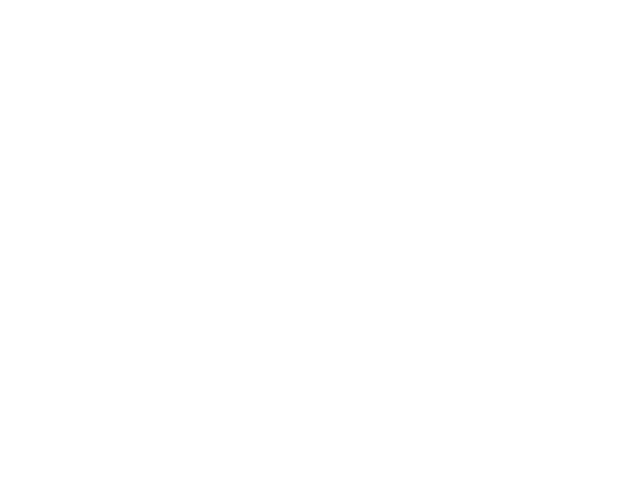

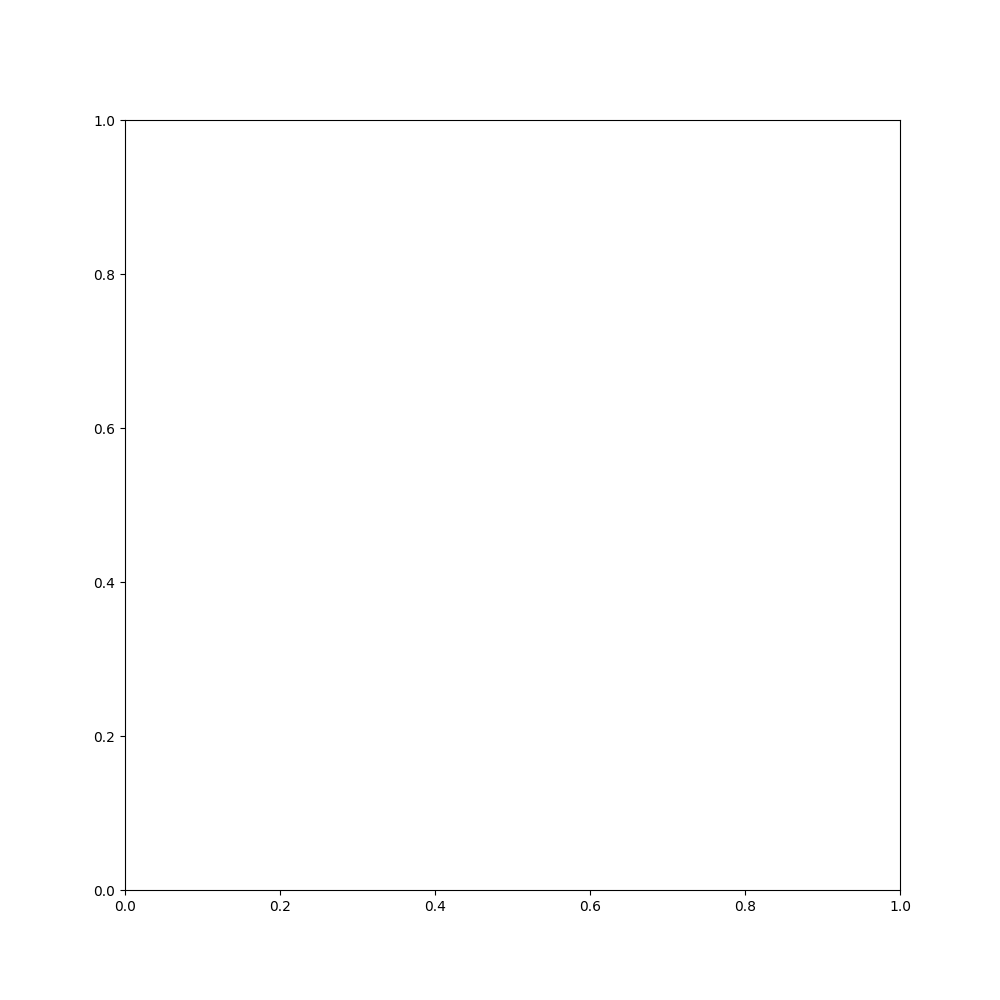

In [8]:
plt.clf()

fig, ax = plt.subplots(figsize=(10,10))
alphas = [1.0, 0.7, 0.5,0.3]


rect, _ = plot_mvvids.get_bounding_box(reconstruction = temp_reconstruction)
output_img_size = (rect[1][1], rect[1][0])#(1920, 1080)
input_img_size = (1080, 1920) # (1920*2, 1080*2)

for_reproj_error = None
for cam in plot_mvvids.cams:
    img = copy.deepcopy(base_frames[cam.name][0])
    # rescale image to 250x180
    img = cv2.resize(img, (input_img_size[1], input_img_size[0]))
    cam.calib_from_reconstruction(reconstruction = temp_reconstruction)
    H = cam.get_ground_plane_homography(input_img_size=input_img_size, output_img_size = output_img_size, 
                                        bounding_box = rect, padding_percent = 0)
    new_img = project_to_ground_plane_cv2(img, H, output_img_size)
    ax.imshow(new_img, alpha = alphas[int(cam.calibration.view_id) - 1])

In [ ]:
from pathlib import Path
# Save updated reconstruction
# new_reconstruction = update_reconstruction(copy.deepcopy(reconstruction), rotation = rotation, origin=origin, scaling = scale)
new_reconstruction_path = os.path.join(data_root, '0-calibration', 'opensfm', 'reconstruction_new.json')
write_json(new_reconstruction_path, [temp_reconstruction])

# Save updated calibrations
for camera in mvvids.cams:
    print(f"Saving calibration data for camera: {camera.name}")
    camera.calib_from_reconstruction(reconstruction = temp_reconstruction)
    camera.calib_path =  Path(data_root) / '0-calibration' / 'calibs' / f'{camera.name}_new.json'
    camera.calibration = camera.calibration._replace(ROI = roi_points[camera.name])
    camera.calibration = camera.calibration._replace(bounding_box = rect)
    camera.save_calibration(calibration = camera.calibration)